# MacOS Configuration
The configuration is for
1. Install boost libs: `brew install boost-python3` (My current version is 1.73.0)
2. Install JUCE (Currently I'm still using JUCE 7)
3. Make sure have python3.8 installed
4. Get RenderMan from https://github.com/fedden/RenderMan
5. Open `RenderMan-py36.jucer` in the project folder, generate XCode project.
6. Configure the search paths in XCode (This could be different, find the corresponding paths on your machine):
   - Boost dylib path: `/usr/local/Cellar/boost-python3/1.73.0/lib`
   - Python dylib path: `/usr/local/Cellar/python@3.8/3.8.5/Frameworks/Python.framework/Versions/3.8/lib`
   - Python header path: `/usr/local/Cellar/python@3.8/3.8.5/Frameworks/Python.framework/Versions/3.8/include/python3.8`
7. Set the link flags: `-shared -lboost_python38 -undefined dynamic_lookup`
7. Build a release build `librenderman.so.dylib`, remove the extra `.dylib` extension.
8. Copy the `librenderman.so` to your python project root directory.

# Example
[RenderMan Example](http://doc.gold.ac.uk/~lfedd001/renderman.html)

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from IPython.display import Audio

# WORKAROUND: This is a hacky solution to get Essentia on macOS
# Essentia only gets installed successfully by homebrew
# https://github.com/MTG/essentia/issues/777
# https://gist.github.com/jarmitage/40e3b7962b0a77a233b2d590d69378d6
import sys
sys.path.append('/usr/local/lib/python3.8/site-packages/')
#import essentia

from essentia import *
from essentia.standard import *


Load the VST plugin and parse the dataset and dump the mean MFCC and binary character arrays

(You don't have to run this if you have done this once)

In [47]:
import librenderman as rm
from dataset_parser import get_patch, character_to_binary

# Important settings. These are good general ones.
sampleRate = 44100
bufferSize = 512
fftSize = 512

# Load the plugin
engine = rm.RenderEngine(sampleRate, bufferSize, fftSize)
path = "/Library/Audio/Plug-Ins/VST/u-he/Diva.vst"
engine.load_plugin(path)

generator = rm.PatchGenerator(engine)

# Note settings
midiNote = 60
midiVelocity = 127
noteLength = 4.0
renderLength = 5.0

# Essentia settings
w = Windowing()
spec = Spectrum()

rms_extractor = RMS()
flux_extractor = Flux()
centroid_extractor = Centroid(range=22050)
rolloff_extractor = RollOff()
decrease_extractor = Decrease()
energy_extractor = Energy()
crest_extractor = Crest()
hfc_extractor = HFC()
strongpeak_extractor = StrongPeak()
zerocrossingrate_extractor = ZeroCrossingRate()
envelope_extractor = Envelope()
logattacktime_extractor = LogAttackTime()



#mean_mfcc_array = []
features = []
binary_characters = []

i = 1

# Iterate
for patch, path, character in get_patch("dataset.json"):
    if not character:
        continue

    binary_character = character_to_binary(character)
    if binary_character == [0]*22:
        continue
    
    engine.set_patch(patch)
    engine.render_patch(midiNote, midiVelocity, noteLength, renderLength)
    audio = np.array(engine.get_audio_frames(), dtype=np.float32)
    
    feature_array = []
    for frame in FrameGenerator(audio, frameSize = 1024, hopSize = 512):
        spectrum = spec(w(frame))
        feature_array.append([
            rms_extractor(spectrum),
            flux_extractor(spectrum),
            centroid_extractor(spectrum),
            rolloff_extractor(spectrum),
            decrease_extractor(spectrum),
            energy_extractor(spectrum),
            crest_extractor(spectrum),
            hfc_extractor(spectrum),
            strongpeak_extractor(spectrum),
            zerocrossingrate_extractor(frame),           
        ])
    
    feature_array = np.array(feature_array, dtype=np.float32)
    feature_means = np.mean(feature_array, axis=0)
    feature_stdevs = np.std(feature_array, axis=0)
    
    # add attack time feature
    feature_means = np.append(feature_means, logattacktime_extractor(envelope_extractor(audio))[0])
    features.append(np.concatenate((feature_means, feature_stdevs)))
    
    #mean_mfcc = np.mean(np.array(engine.get_mfcc_frames()), axis=0)
    #print(features)
    #mean_mfcc_array.append(mean_mfcc)
    binary_characters.append(binary_character)
    
    print("Iteration:", i)
    i += 1

#mean_mfcc_array = np.array(mean_mfcc_array)
features = np.array(features)
binary_characters = np.array(binary_characters)

# Dump the data
with open('features.pkl', 'wb') as f:
    pickle.dump(features, f)

with open('binary_characters.pkl', 'wb') as f:
    pickle.dump(binary_characters, f)

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59
Iteration: 60
Iteration: 61
Iteration: 62
Iteration: 63
Iteration: 64
Iteration: 65
Iteration: 66
Iteration: 67
Iteration: 68
Iteration: 69
Iteration: 70
Iteration: 71
Iteration: 72
I

Iteration: 555
Iteration: 556
Iteration: 557
Iteration: 558
Iteration: 559
Iteration: 560
Iteration: 561
Iteration: 562
Iteration: 563
Iteration: 564
Iteration: 565
Iteration: 566
Iteration: 567
Iteration: 568
Iteration: 569
Iteration: 570
Iteration: 571
Iteration: 572
Iteration: 573
Iteration: 574
Iteration: 575
Iteration: 576
Iteration: 577
Iteration: 578
Iteration: 579
Iteration: 580
Iteration: 581
Iteration: 582
Iteration: 583
Iteration: 584
Iteration: 585
Iteration: 586
Iteration: 587
Iteration: 588
Iteration: 589
Iteration: 590
Iteration: 591
Iteration: 592
Iteration: 593
Iteration: 594
Iteration: 595
Iteration: 596
Iteration: 597
Iteration: 598
Iteration: 599
Iteration: 600
Iteration: 601
Iteration: 602
Iteration: 603
Iteration: 604
Iteration: 605
Iteration: 606
Iteration: 607
Iteration: 608
Iteration: 609
Iteration: 610
Iteration: 611
Iteration: 612
Iteration: 613
Iteration: 614
Iteration: 615
Iteration: 616
Iteration: 617
Iteration: 618
Iteration: 619
Iteration: 620
Iteration:

Iteration: 1095
Iteration: 1096
Iteration: 1097
Iteration: 1098
Iteration: 1099
Iteration: 1100
Iteration: 1101
Iteration: 1102
Iteration: 1103
Iteration: 1104
Iteration: 1105
Iteration: 1106
Iteration: 1107
Iteration: 1108
Iteration: 1109
Iteration: 1110
Iteration: 1111
Iteration: 1112
Iteration: 1113
Iteration: 1114
Iteration: 1115
Iteration: 1116
Iteration: 1117
Iteration: 1118
Iteration: 1119
Iteration: 1120
Iteration: 1121
Iteration: 1122
Iteration: 1123
Iteration: 1124
Iteration: 1125
Iteration: 1126
Iteration: 1127
Iteration: 1128
Iteration: 1129
Iteration: 1130
Iteration: 1131
Iteration: 1132
Iteration: 1133
Iteration: 1134
Iteration: 1135
Iteration: 1136
Iteration: 1137
Iteration: 1138
Iteration: 1139
Iteration: 1140
Iteration: 1141
Iteration: 1142
Iteration: 1143
Iteration: 1144
Iteration: 1145
Iteration: 1146
Iteration: 1147
Iteration: 1148
Iteration: 1149
Iteration: 1150
Iteration: 1151
Iteration: 1152
Iteration: 1153
Iteration: 1154
Iteration: 1155
Iteration: 1156
Iteratio

Iteration: 1609
Iteration: 1610
Iteration: 1611
Iteration: 1612
Iteration: 1613
Iteration: 1614
Iteration: 1615
Iteration: 1616
Iteration: 1617
Iteration: 1618
Iteration: 1619
Iteration: 1620
Iteration: 1621
Iteration: 1622
Iteration: 1623
Iteration: 1624
Iteration: 1625
Iteration: 1626
Iteration: 1627
Iteration: 1628
Iteration: 1629
Iteration: 1630
Iteration: 1631
Iteration: 1632
Iteration: 1633
Iteration: 1634
Iteration: 1635
Iteration: 1636
Iteration: 1637
Iteration: 1638
Iteration: 1639
Iteration: 1640
Iteration: 1641
Iteration: 1642
Iteration: 1643
Iteration: 1644
Iteration: 1645
Iteration: 1646
Iteration: 1647
Iteration: 1648
Iteration: 1649
Iteration: 1650
Iteration: 1651
Iteration: 1652
Iteration: 1653
Iteration: 1654
Iteration: 1655
Iteration: 1656
Iteration: 1657
Iteration: 1658
Iteration: 1659
Iteration: 1660
Iteration: 1661
Iteration: 1662
Iteration: 1663
Iteration: 1664
Iteration: 1665
Iteration: 1666
Iteration: 1667
Iteration: 1668
Iteration: 1669
Iteration: 1670
Iteratio

Iteration: 2124
Iteration: 2125
Iteration: 2126
Iteration: 2127
Iteration: 2128
Iteration: 2129
Iteration: 2130
Iteration: 2131
Iteration: 2132
Iteration: 2133
Iteration: 2134
Iteration: 2135
Iteration: 2136
Iteration: 2137
Iteration: 2138
Iteration: 2139
Iteration: 2140
Iteration: 2141
Iteration: 2142
Iteration: 2143
Iteration: 2144
Iteration: 2145
Iteration: 2146
Iteration: 2147
Iteration: 2148
Iteration: 2149
Iteration: 2150
Iteration: 2151
Iteration: 2152
Iteration: 2153
Iteration: 2154
Iteration: 2155
Iteration: 2156
Iteration: 2157
Iteration: 2158
Iteration: 2159
Iteration: 2160
Iteration: 2161
Iteration: 2162
Iteration: 2163
Iteration: 2164
Iteration: 2165
Iteration: 2166
Iteration: 2167
Iteration: 2168
Iteration: 2169
Iteration: 2170
Iteration: 2171
Iteration: 2172
Iteration: 2173
Iteration: 2174
Iteration: 2175
Iteration: 2176
Iteration: 2177
Iteration: 2178
Iteration: 2179
Iteration: 2180
Iteration: 2181
Iteration: 2182
Iteration: 2183
Iteration: 2184
Iteration: 2185
Iteratio

Iteration: 2637
Iteration: 2638
Iteration: 2639
Iteration: 2640
Iteration: 2641
Iteration: 2642
Iteration: 2643
Iteration: 2644
Iteration: 2645
Iteration: 2646
Iteration: 2647
Iteration: 2648
Iteration: 2649
Iteration: 2650
Iteration: 2651
Iteration: 2652
Iteration: 2653
Iteration: 2654
Iteration: 2655
Iteration: 2656
Iteration: 2657
Iteration: 2658
Iteration: 2659
Iteration: 2660
Iteration: 2661
Iteration: 2662
Iteration: 2663
Iteration: 2664
Iteration: 2665
Iteration: 2666
Iteration: 2667
Iteration: 2668
Iteration: 2669
Iteration: 2670
Iteration: 2671
Iteration: 2672
Iteration: 2673
Iteration: 2674
Iteration: 2675
Iteration: 2676
Iteration: 2677
Iteration: 2678
Iteration: 2679
Iteration: 2680
Iteration: 2681
Iteration: 2682
Iteration: 2683
Iteration: 2684
Iteration: 2685
Iteration: 2686
Iteration: 2687
Iteration: 2688
Iteration: 2689
Iteration: 2690
Iteration: 2691
Iteration: 2692
Iteration: 2693
Iteration: 2694
Iteration: 2695
Iteration: 2696
Iteration: 2697
Iteration: 2698
Iteratio

Iteration: 3151
Iteration: 3152
Iteration: 3153
Iteration: 3154
Iteration: 3155
Iteration: 3156
Iteration: 3157
Iteration: 3158
Iteration: 3159
Iteration: 3160
Iteration: 3161
Iteration: 3162
Iteration: 3163
Iteration: 3164
Iteration: 3165
Iteration: 3166
Iteration: 3167
Iteration: 3168
Iteration: 3169
Iteration: 3170
Iteration: 3171
Iteration: 3172
Iteration: 3173
Iteration: 3174
Iteration: 3175
Iteration: 3176
Iteration: 3177
Iteration: 3178
Iteration: 3179
Iteration: 3180
Iteration: 3181
Iteration: 3182
Iteration: 3183
Iteration: 3184
Iteration: 3185
Iteration: 3186
Iteration: 3187
Iteration: 3188
Iteration: 3189
Iteration: 3190
Iteration: 3191
Iteration: 3192
Iteration: 3193
Iteration: 3194
Iteration: 3195
Iteration: 3196
Iteration: 3197
Iteration: 3198
Iteration: 3199
Iteration: 3200
Iteration: 3201
Iteration: 3202
Iteration: 3203
Iteration: 3204
Iteration: 3205
Iteration: 3206
Iteration: 3207
Iteration: 3208
Iteration: 3209
Iteration: 3210
Iteration: 3211
Iteration: 3212
Iteratio

Load the serialized data

In [31]:
with open('features.pkl', 'rb') as f:
    features = pickle.load(f)
    
with open('binary_characters.pkl', 'rb') as f:
    binary_characters = pickle.load(f)

PCA

In [29]:
from sklearn.decomposition import PCA, KernelPCA

#pca = PCA(n_components=2)
kpca = KernelPCA(n_components=2, kernel='linear')

features_pca = kpca.fit_transform(mean_mfcc_array)

NameError: name 'KernalPCA' is not defined

Plot

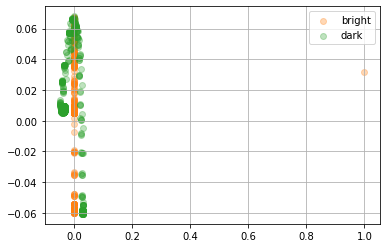

In [27]:
#%matplotlib inline

# https://necromuralist.github.io/neural_networks/posts/normalizing-with-numpy/
def normalize_cols(x: np.ndarray):
    """
    function that normalizes each column of the matrix x to have unit length.

    Args:
     ``x``: A numpy matrix of shape (n, m)

    Returns:
     ``x``: The normalized (by row) numpy matrix.
    """
    return x/np.linalg.norm(x, ord=2, axis=0, keepdims=True)

# Bright and Dark
idx_bright = np.where(1 == binary_character_array[:, 0])
idx_dark = np.where(1 == binary_character_array[:, 1])

samples_bright = normalize_cols(mean_mfcc_pca[idx_bright])
samples_dark = normalize_cols(mean_mfcc_pca[idx_dark])

# https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/scatter_with_legend.html#sphx-glr-gallery-lines-bars-and-markers-scatter-with-legend-py
color_bright = 'tab:orange'
color_dark = 'tab:green'
fig, ax = plt.subplots()
ax.scatter(samples_bright[:, 0], samples_bright[:, 1], c=color_bright, label='bright', alpha=0.3)
ax.scatter(samples_dark[:, 0], samples_dark[:, 1], c=color_dark, label='dark', alpha=0.3)

ax.legend()
ax.grid(True)

plt.show()

In [28]:
x = np.array([[0, 0, 1], 
              [1, 0, 0],
              [1, 1, 0]])

np.where(x == 1)

samples_bright = mean_mfcc_pca[idx_bright]

samples_bright

array([[-9.89490245e-04,  2.25303734e-04],
       [ 8.76484742e-01,  7.74132166e-04],
       [-9.56911111e-04,  8.48041920e-04],
       ...,
       [-9.75032847e-04,  1.91644459e-04],
       [-1.03146521e-03,  2.27994142e-04],
       [ 8.68205310e-04, -1.45362784e-03]])

Text(0.5, 0, 'Time (frame count)')

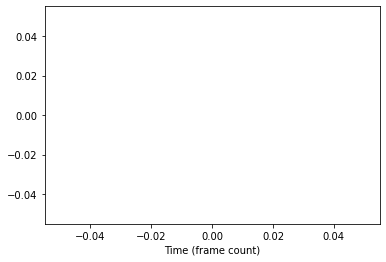

In [3]:
%matplotlib inline

plt.plot(audio)
plt.xlabel('Time (frame count)')

<ipython-input-17-65cfdae9bada>:2: UserWarning: Only one segment is calculated since parameter NFFT (=512) >= signal length (=0).
  plt.specgram(audio, NFFT=512, Fs=sampleRate, noverlap=256)


Text(0, 0.5, 'Frequency')

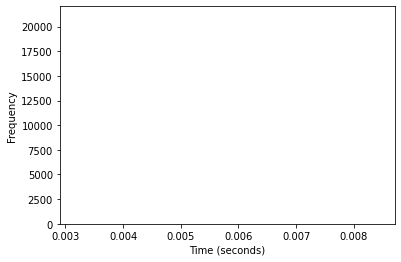

In [17]:
# Plot a spectrogram
plt.specgram(audio, NFFT=512, Fs=sampleRate, noverlap=256)
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency')

In [9]:

Audio(audio, rate=sampleRate)

ValueError: zero-size array to reduction operation maximum which has no identity

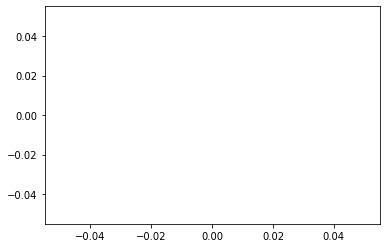

In [9]:
import librenderman as rm

# Create a patch generator. We can initialise it to generate the correct
# patches for a given synth by passing it a RenderEngine which has
# loaded a instance of the synthesiser. 

# Important settings. These are good general ones.
sampleRate = 44100
bufferSize = 512
fftSize = 512

# Note settings
midiNote = 60
midiVelocity = 127
noteLength = 4.0
renderLength = 5.0


# Load the plugin
engine = rm.RenderEngine(sampleRate, bufferSize, fftSize)
#path = "/Library/Audio/Plug-Ins/VST/u-he/Diva.vst"
path = "/Library/Audio/Plug-Ins/VST/helm.vst"
engine.load_plugin(path)

generator = rm.PatchGenerator(engine)
new_patch = generator.get_random_patch()
#new_patch = get_mapped_patch("MK Planet Earth.h2p")
#xx_patch = []
#for p in new_patch:
#    xx_patch.append((p[0], p[1]/100.0))

engine.set_patch(new_patch)
#engine.override_plugin_parameter(0, 100)



# Render the data. 


# Get the data. Note the audio is automattically made mono, no
# matter what channel size for ease of use.
audio = engine.get_audio_frames()
#mfccs = engine.get_mfcc_features()

plt.plot(audio)